# (0) Download Butterfly 

In [ ]:
!kaggle datasets download -d gpiosenka/butterfly-images40-species

In [1]:
import zipfile
with zipfile.ZipFile('butterfly-images40-species.zip', 'r') as zip_ref:
    zip_ref.extractall('data/butterfly')

# (1) Process Butterfly Data

In [1]:
from utils.data import create_butterfly_dataset
trainset, testset, normal_mapping, reverse_mapping, image_dict = create_butterfly_dataset()
assert len(trainset) == 12594, 'Size of train set not match'
assert len(testset) == 500, 'Size of test set not match'

# (2) Import Classifier

In [2]:
from model.butterfly_classifier import DenseNet121
import torch

model = DenseNet121(num_classes=len(normal_mapping)).to('cuda')
model.load_state_dict(torch.load('./model/states/butterfly_classifier.pth'))

<All keys matched successfully>

In [35]:
image_dict['ADONIS'].unsqueeze(0)

tensor([[[[0.0000, 0.0000, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0118, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0275, 0.0510,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3373, 0.3255, 0.2627,  ..., 0.0000, 0.0078, 0.0118],
          [0.3373, 0.3176, 0.2627,  ..., 0.0000, 0.0039, 0.0039],
          [0.3412, 0.3059, 0.2588,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0235, 0.0510, 0.0941,  ..., 0.0157, 0.0157, 0.0196],
          [0.0353, 0.0667, 0.1137,  ..., 0.0118, 0.0157, 0.0196],
          [0.0431, 0.0824, 0.1294,  ..., 0.0118, 0.0157, 0.0196],
          ...,
          [0.4392, 0.4275, 0.3608,  ..., 0.0196, 0.0275, 0.0314],
          [0.4392, 0.4078, 0.3490,  ..., 0.0196, 0.0235, 0.0275],
          [0.4353, 0.3961, 0.3412,  ..., 0.0196, 0.0235, 0.0235]],

         [[0.0196, 0.0118, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0196, 0.0157, 0.0157,  ..., 0.0000, 0.0000, 0.0039],
          [0.0118, 0.0235, 0.0196,  ..., 0

In [38]:
test_img

tensor([[[[0.1882, 0.2235, 0.1843,  ..., 0.2314, 0.3216, 0.3922],
          [0.1843, 0.1882, 0.1765,  ..., 0.2314, 0.2824, 0.3647],
          [0.1882, 0.1804, 0.2118,  ..., 0.2353, 0.2980, 0.3451],
          ...,
          [0.2000, 0.2275, 0.2353,  ..., 0.5451, 0.5490, 0.5373],
          [0.2275, 0.2392, 0.2196,  ..., 0.5451, 0.5608, 0.5765],
          [0.2118, 0.2314, 0.2078,  ..., 0.5647, 0.5843, 0.5882]],

         [[0.3843, 0.4196, 0.3804,  ..., 0.3137, 0.3843, 0.4431],
          [0.3804, 0.3843, 0.3725,  ..., 0.3294, 0.3647, 0.4314],
          [0.3843, 0.3765, 0.4078,  ..., 0.3529, 0.3961, 0.4314],
          ...,
          [0.4392, 0.4667, 0.4745,  ..., 0.7137, 0.7216, 0.7098],
          [0.4667, 0.4824, 0.4627,  ..., 0.7176, 0.7373, 0.7569],
          [0.4549, 0.4745, 0.4510,  ..., 0.7373, 0.7608, 0.7647]],

         [[0.1843, 0.2196, 0.1804,  ..., 0.0824, 0.1294, 0.1608],
          [0.1804, 0.1843, 0.1725,  ..., 0.1020, 0.1020, 0.1529],
          [0.1843, 0.1686, 0.2000,  ..., 0

# (3) Evaluate Untargeted Adversarial Examples

In [3]:
from torch.utils.data import DataLoader
from utils.base import eval_accuracy


acc = eval_accuracy(model, testset,  batch_size=100)
print('Accuracy on test set is {}'.format(acc))

Accuracy on test set is 0.9640000462532043


In [37]:
from tqdm import tqdm 
import torch
import torch.nn.functional as F
from torch import nn
test_img, test_label = testset[5]
test_img = test_img.unsqueeze(0).to('cuda')
model.eval()
reverse_mapping[torch.topk(F.softmax(model(test_img), dim = 1), k=5)[1][0][1].cpu().item()]

'COMMON WOOD-NYMPH'

In [13]:
from algo.attacker import adversarial_generator

test_img, test_label = testset[5]
test_img = test_img.unsqueeze(0)

adv_img = adversarial_generator(model = model, target_class=test_label,
                             image=test_img, 
                             search_var=1e-3,
                             sample_num=50,
                             bound=0.1,
                             lr=0.01,
                             query_limit=3000)

SyntaxError: '(' was never closed (attacker.py, line 178)

In [ ]:
import torch.nn.functional as F

adv_logits = model(adv_img)
org_logits = model(test_img.to('cuda'))

print('Adversarial: predicted class is {}'.format(torch.argmax(adv_logits, dim=1)))
print('Original: predicted class is {}'.format(torch.argmax(org_logits, dim=1)))

print('Adversarial: logit of true class is {}'.format(adv_logits[0, test_label]))
print('Original: logit of true class is {}'.format(org_logits[0, test_label]))

print('Adversarial: probability of true class is {}'.format(F.softmax(adv_logits, dim=1)[0, test_label]))
print('Original: probability of true class is {}'.format(F.softmax(org_logits, dim=1)[0, test_label]))

In [24]:
from tqdm import tqdm 
import torch
import torch.nn.functional as F
from torch import nn
def NES(model, target_class, image, search_var, sample_num, g, u):
    #parameters
    n = sample_num #should be even
    N = image.size(2) #assume the image is N x N may subject to change
    
    #NES estimation
    g.zero_()
    with torch.no_grad():
        for i in range(n):
            u.normal_()
            g = g + F.softmax(model(image + search_var * u), dim =1)[0,target_class] * u
            g = g - F.softmax(model(image - search_var * u), dim =1)[0,target_class] * u #we assume the output of the model is ordered by class index
    return 1 / (2*n*search_var) * g

def PIA_adversarial_generator(model, initial_image, image, target_class, epsilon_adv, epsilon_0, search_var, sample_num, delta_epsilon, eta_max, eta_min, k=5):
    device = next(model.parameters()).device
    initial_image, image = initial_image.to(device), image.to(device)
    x_adv = image.clone()
    N = initial_image.size(2)
    g = torch.zeros(N, requires_grad=False).to(device)
    u = torch.randn((N, N)).to(device)
    
    epsilon = epsilon_0
    x_adv = torch.clamp(x_adv, initial_image - epsilon, initial_image + epsilon)
    new_class = target_class
    
    with torch.no_grad():
        time = 1
        while ((epsilon > epsilon_adv) | (new_class != target_class)) and (time != 200):
            if time%20 == 0:
                print("20 times")
                print(top_classes)
                print(epsilon)
                print(F.softmax(model(x_adv), dim=1))
            time += 1
            gradient = NES(model, target_class, x_adv, search_var, sample_num, g, u)
            eta = eta_max
            x_adv_hat = x_adv - eta * gradient
            probabilities_adv = F.softmax(model(x_adv_hat), dim=1)
            top_probs, top_classes = torch.topk(probabilities_adv, k)
            while not target_class in top_classes[0]:
                if eta < eta_min:
                    epsilon += delta_epsilon
                    delta_epsilon /= 2
                    x_adv_hat = x_adv
                    break  
                eta /= 2
                x_adv_hat = torch.clamp(x_adv - eta * gradient, initial_image - epsilon, initial_image + epsilon)
                probabilities_adv = F.softmax(model(x_adv_hat), dim=1)
                top_probs, top_classes = torch.topk(probabilities_adv, k)
            x_adv = x_adv_hat
            epsilon = epsilon - delta_epsilon
            new_class = torch.argmax(model(x_adv))
    return x_adv

In [5]:
test_img, test_label = testset[3]
test_img = test_img.unsqueeze(0)
initial_img, initial_label = testset[111]
initial_img = initial_img.unsqueeze(0)

In [6]:
print(initial_label)
print(test_label)

15
6


In [7]:
model.eval()
torch.argmax(model(initial_img.to('cuda')), dim=1)

tensor([15], device='cuda:0')

In [25]:
adv_img = PIA_adversarial_generator(model, initial_image = initial_img, 
                                    image = test_img, target_class = test_label,
                                    epsilon_adv = 0.05, epsilon_0 = 0.5,
                                    search_var = 1e-3, sample_num = 50,
                                    delta_epsilon = 1e-3, 
                                    eta_max = 0.01, eta_min = 0.005,
                                    k=5)

20 times
tensor([[81,  6, 58, 94, 47]], device='cuda:0')
0.481
tensor([[5.6146e-07, 6.7062e-05, 1.6767e-07, 1.2321e-05, 1.3447e-05, 1.2794e-08,
         1.2157e-01, 4.8283e-04, 5.8318e-07, 2.4175e-03, 2.3673e-07, 2.5082e-07,
         2.3341e-08, 1.1735e-07, 1.2954e-05, 5.6366e-08, 6.0700e-05, 9.1841e-09,
         3.3532e-06, 1.8836e-07, 1.5805e-04, 8.7621e-07, 2.9461e-05, 1.1254e-04,
         3.2649e-05, 2.4213e-04, 3.1839e-07, 2.4491e-09, 2.7220e-07, 7.6593e-08,
         1.0059e-07, 8.3189e-04, 4.9126e-06, 7.5403e-05, 5.1935e-05, 3.1554e-07,
         2.1236e-06, 1.2272e-06, 1.3331e-04, 4.5752e-06, 7.6321e-05, 2.5247e-07,
         2.3895e-04, 5.1055e-04, 2.3539e-06, 3.6206e-05, 3.3728e-07, 1.0510e-02,
         5.2721e-06, 2.0638e-07, 3.6052e-04, 2.1860e-06, 4.1761e-07, 8.6796e-07,
         3.8225e-06, 7.1712e-06, 1.9295e-07, 3.5265e-08, 3.6812e-02, 3.3107e-09,
         7.8201e-06, 3.2923e-08, 3.1258e-07, 3.3298e-08, 1.4840e-05, 2.3799e-04,
         5.7914e-08, 2.8364e-07, 7.6174e-08, 5

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_adv is a PyTorch tensor with shape [C, H, W]
# where C is the number of channels, H is the height, and W is the width.

# Move the tensor to the CPU and convert to a NumPy array
image_np1 = adv_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np1.ndim == 3:
    # Transpose the image for plotting
    image_np1 = image_np1.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np1.max() <= 1.0:
    image_np1 = (image_np1 * 255).astype(np.uint8)


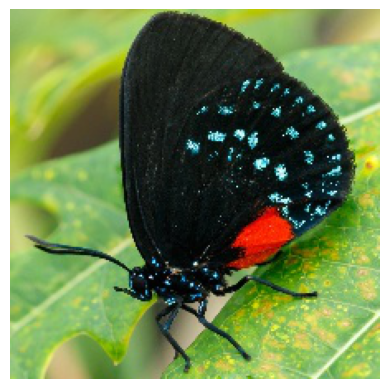

In [31]:
image_np = test_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np.ndim == 3:
    # Transpose the image for plotting
    image_np = image_np.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np.max() <= 1.0:
    image_np = (image_np * 255).astype(np.uint8)

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Hide the axis
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

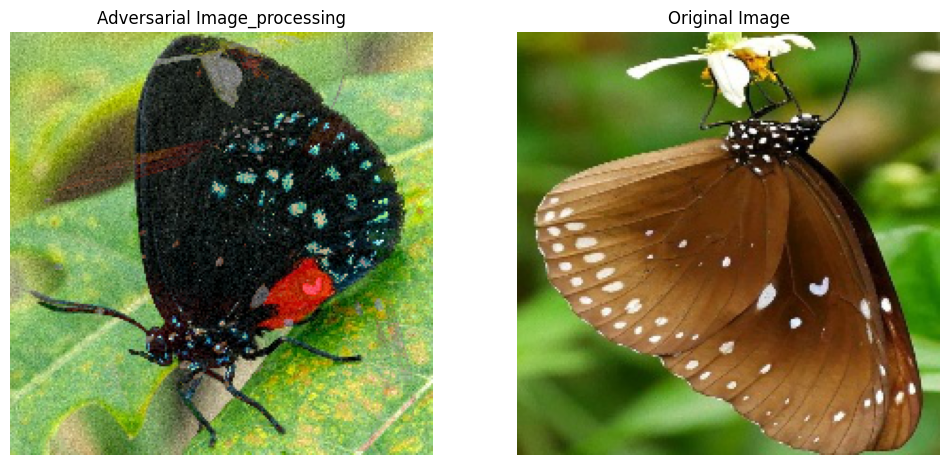

In [38]:
image_np2 = initial_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np2.ndim == 3:
    # Transpose the image for plotting
    image_np2 = image_np2.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np2.max() <= 1.0:
    image_np2 = (image_np2 * 255).astype(np.uint8)

# Plot the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np1)
plt.title('Adversarial Image_processing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_np2)
plt.title('Original Image')
plt.axis('off')
